     Gender  Programme  Grade  Total  MCQ  Q1  Q2  Q3    Q4  Q5
0         1          3      3   45.0   21   8   4   2  10.0   0
1         2          3      3   43.0   21   4   2   8   8.0   0
2         1          4      2   26.0   24   0   0   2   0.0   0
3         2          1      3   30.0   24   4   0   0   0.0   2
4         1          2      3   27.0   21   0   2   4   0.0   0
..      ...        ...    ...    ...  ...  ..  ..  ..   ...  ..
614       2          1      2   55.0   33   6   4   4   8.0   0
615       2          4      2   41.0   27   6   4   4   0.0   0
616       2          1      2   73.0   36   8   8  11  10.0   0
617       2          1      2   77.0   42   8   8   6  10.0   3
618       2          1      2   22.0   12   4   0   4   2.0   0

[548 rows x 10 columns] cleaned_dataframe
     Gender  Programme  Grade  Total  MCQ  Q1  Q2  Q3    Q4  Q5
6         2          4      2   49.0   33   8   2   6   0.0   0
9         2          1      2   54.0   33   6   2   4   8.0  

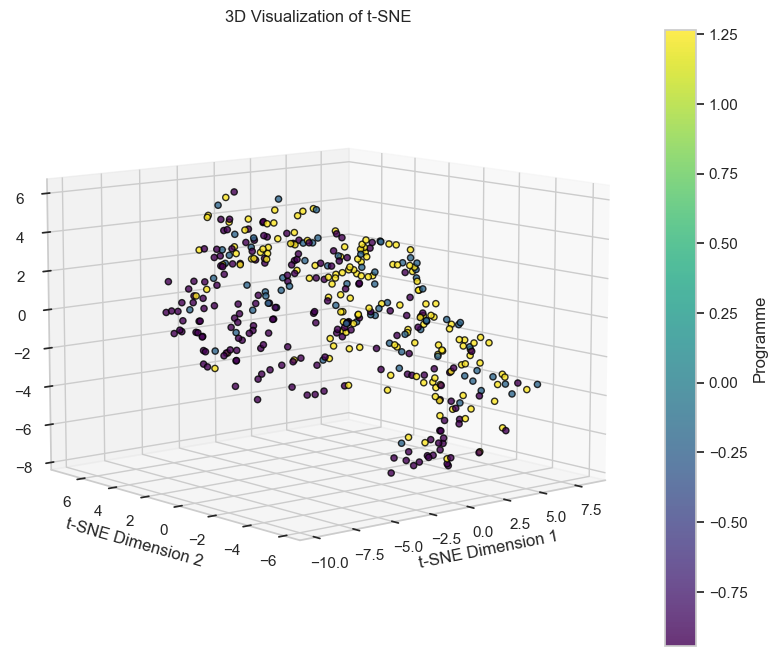

     Dimension 1  Dimension 2  Dimension 3     Label
0       3.788068     3.518480     1.170740  1.265232
1      -0.573904     6.537866     3.948063 -0.944780
2      -2.936833    -2.601856     2.997625  1.265232
3       2.862993    -0.927217     2.007205 -0.944780
4      -3.864405     4.509174     1.483908 -0.208109
..           ...          ...          ...       ...
395    -7.675832    -1.389605     3.828879  1.265232
396     4.484866     3.835159     0.457970 -0.208109
397    -0.310592     6.925613     3.315746 -0.944780
398     6.186836     1.107908     0.869568  1.265232
399    -2.096128    -3.708435    -1.882839 -0.944780

[400 rows x 4 columns]


In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, gaussian_kde
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import NMF, PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 读取源文件
raw_dataset = pd.read_csv("CW_Data.csv")
# 去除index
raw_dataframe = pd.DataFrame(raw_dataset.iloc[:, 1:11])
# 由于所有Programme3的人都是grade3，绝大多数grade3的同学都是Programme3，可以移除grade3这一特征。


# 去除所有成绩相同的行
# 创建一个包含要检查的列的子集
subset = raw_dataframe[['Total', 'MCQ', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
# 查找重复的行
duplicates = subset.duplicated(keep=False)
# 删除重复的行，保留所有其他列
cleaned_dataframe = raw_dataframe[~duplicates]
# 输出清理后的DataFrame，548行
print(cleaned_dataframe, 'cleaned_dataframe')
# 使用Isolation Forest方法去除异常值
from sklearn.ensemble import IsolationForest
# 选择特征列，排除不需要的列（如索引或标签）
X_iso_progress = cleaned_dataframe.drop(['Gender', 'Programme'], axis=1)
# 初始化Isolation Forest模型，设置contamination参数为异常值的预期比例
clf = IsolationForest(contamination='auto', random_state=0)
# 拟合模型并预测异常值
y_pred = clf.fit_predict(X_iso_progress)
# 找出异常值的索引，-1表示异常值
outlier_indices = y_pred == -1
# 去除异常值的行
cleaned_iso_dataframe = cleaned_dataframe.loc[~outlier_indices]
# 显示清理后的DataFrame
print(cleaned_iso_dataframe, 'cleaned_iso_dataframe')


scaler = StandardScaler()
# 对去除3的情况t-sne降维
zscore_cleaned_iso_data = scaler.fit_transform(cleaned_iso_dataframe)
# 获取原始的列名
column_names = cleaned_iso_dataframe.columns
# 将标准化后的数据转换为 DataFrame，并设置列名
zscore_cleaned_iso_dataframe = pd.DataFrame(zscore_cleaned_iso_data, columns=column_names)
X_iso = zscore_cleaned_iso_dataframe[['MCQ', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
y_iso = zscore_cleaned_iso_dataframe['Programme']
# 对使用的数据集标准化
x_iso_scaled = scaler.fit_transform(X_iso)
# 应用t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_iso_tsne = tsne.fit_transform(x_iso_scaled)

# 3维
# 应用t-SNE
tsne3 = TSNE(n_components=3, random_state=0)
X_tsne3 = tsne3.fit_transform(x_iso_scaled)
tsne_df = pd.DataFrame(X_tsne3, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
# 假设 y 是与 X_tsne 相对应的标签序列
# 我们可以将 y 添加到 tsne_df 中作为一个新的列，用于在 seaborn 中设置 hue
tsne_df['Label'] = y_iso
# # 将DataFrame保存为CSV文件  
# tsne_df.to_csv('tsne_data.csv', index=False)  # index=False表示不保存行索引

# 创建三维散点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用不同的颜色表示不同的标签
sc = ax.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], tsne_df['Dimension 3'], c=tsne_df['Label'],
                cmap='viridis', marker='o', edgecolor='black', alpha=0.8)
# 添加颜色条
plt.colorbar(sc, label='Programme')
# 设置轴标签
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
# 设置图表标题
ax.set_title('3D Visualization of t-SNE')
ax.view_init(elev=10., azim=230)  # 设置仰角为30度，方位角为45度
# 显示图表
# %matplotlib notebook
plt.show()
print(tsne_df)

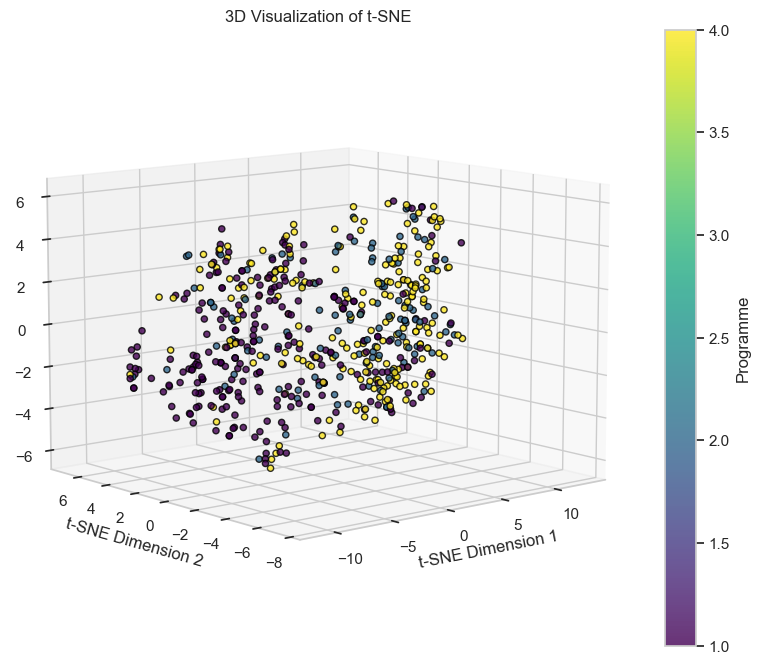

     Gender  Total  Q1  Q2  Q3    Q4  Q5  Dimension 1  Dimension 2  \
0         1   26.0   0   0   2   0.0   0    11.412515     2.314423   
1         2   81.0   8   8   6   8.0   3    -2.767754     5.899757   
2         2   49.0   8   2   6   0.0   0     6.320778     0.195183   
3         2   54.0   6   2   4   8.0   1     3.100102     3.693123   
4         1   32.0   6   2   0   0.0   0     9.363083     2.460160   
..      ...    ...  ..  ..  ..   ...  ..          ...          ...   
576       2   55.0   6   4   4   8.0   0     3.316008     3.649881   
577       2   41.0   6   4   4   0.0   0     8.603132     3.361178   
578       2   73.0   8   8  11  10.0   0    -4.806017    -5.145881   
579       2   77.0   8   8   6  10.0   3    -2.658135     5.867207   
580       2   22.0   4   0   4   2.0   0    11.329054     1.141265   

     Dimension 3  
0       1.595235  
1      -2.385715  
2      -2.936220  
3      -0.110521  
4      -1.934146  
..           ...  
576    -1.438674  
577    

In [1]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')
sns.set_palette('coolwarm')

# 加载数据集
data_no_g3 = pd.read_csv("cw_data_clear_grade3.csv")

X = data_no_g3[['Total','MCQ','Q1','Q2','Q3','Q4','Q5']]  # 特征 MCQ  Q1  Q2  Q3  Q4  Q5
y = data_no_g3['Programme']  # 目标变量（Programme）

# 使用StandardScaler进行zscore标准化
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)


# 应用t-SNE
tsne3 = TSNE(n_components=3, random_state=0)
X_tsne3 = tsne3.fit_transform(x_scaled)
tsne_df = pd.DataFrame(X_tsne3, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
# 假设 y 是与 X_tsne 相对应的标签序列
# 我们可以将 y 添加到 tsne_df 中作为一个新的列，用于在 seaborn 中设置 hue
tsne_df['Label'] = y
# 创建三维散点图
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图，使用不同的颜色表示不同的标签
sc = ax.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], tsne_df['Dimension 3'], c=tsne_df['Label'],
                cmap='viridis', marker='o', edgecolor='black', alpha=0.8)
# 添加颜色条
plt.colorbar(sc, label='Programme')
# 设置轴标签
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
# 设置图表标题
ax.set_title('3D Visualization of t-SNE')
ax.view_init(elev=10., azim=230)  # 设置仰角为30度，方位角为45度
# 显示图表
plt.show()
# %matplotlib notebook

X = data_no_g3[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']]  # Features
y = data_no_g3['Programme']  # Target variable

X_join_tsne = X.join(tsne_df[['Dimension 1', 'Dimension 2', 'Dimension 3']])
print(X_join_tsne)

In [6]:
# # 决策树
# X_in_tsne = X_join_tsne[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Dimension 1','Dimension 2','Dimension 3']]  # 特征
# y_in_tsne = y  # 目标变量
# from sklearn.model_selection import GridSearchCV
# 
# # 使用网格法优化剪枝
# from sklearn.metrics import recall_score, f1_score, classification_report
# 
# # # 决策树分类器
# # # 分离特征和目标变量
# # X = data_no_g3[['Gender','Total','Q1','Q2','Q3','Q4','Q5']]  # 特征
# # y = data_no_g3['Programme']  # 目标变量（Programme）
# 
# # 确保X的列名是字符串
# X.columns = X.columns.astype(str)
# # 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X_in_tsne, y_in_tsne, test_size=0.46, random_state=42)
# 
# clf2 = DecisionTreeClassifier()
# 
# # 定义要搜索的参数网格  
# param_grid = {  
#     'max_depth': [i for i in range(2, 10, 1)],  
#     'min_samples_split': [i for i in range(1, 25, 2)],  
#     'min_samples_leaf': [i for i in range(1, 20, 1)],  
# }  
# # 创建GridSearchCV实例  
# grid_search = GridSearchCV(estimator=clf2, param_grid=param_grid, cv=5, n_jobs=8)  
# # 使用GridSearchCV拟合数据  
# grid_search.fit(X_train, y_train)  
# # 获取最佳参数  
# best_params = grid_search.best_params_  
# print(f"Best parameters: {best_params}")  
# 
# # 获取最佳模型  
# best_dt_model = grid_search.best_estimator_  
# # 使用最佳模型进行预测  
# y_pred = best_dt_model.predict(X_test)  
# 
# # 计算准确度  
# accuracy = accuracy_score(y_test, y_pred)  
# print(f"Accuracy: {accuracy}")
# # 计算召回率  
# # 注意：recall_score 需要一个额外的参数 'average'，指定如何计算多分类问题的召回率  
# # 例如，可以使用 'micro', 'macro', 'weighted' 或针对每个类别的列表/数组  
# recall = recall_score(y_test, y_pred, average='macro')  # 假设你想要计算宏平均召回率  
# print(f"Recall: {recall}")
# # 计算 F1 分数  
# # 同样，f1_score 也需要一个 'average' 参数  
# f1 = f1_score(y_test, y_pred, average='macro')  # 假设你想要计算宏平均 F1 分数  
# print(f"F1 Score: {f1}")
# # 或者，你可以使用 classification_report 来获取一个包含多个指标的详细报告  
# report = classification_report(y_test, y_pred)  
# print(report)
# 
# # # 获取所有唯一的类标签，并将它们转换为字符串（如果它们不是字符串的话）
# # class_labels = y.unique().astype(str)
# 
# # 可视化决策树
# class_names_str = [str(cls) for cls in sorted(y.unique())]  # 将类别转换为字符串
# plt.figure(figsize=(25,10))
# plot_tree(best_dt_model, filled=True, feature_names=X.columns.tolist(), class_names=class_names_str, fontsize=12)
# plt.title('Decision Tree showing the splits at each node')
# plt.show()
# 
# 
# from sklearn.metrics import confusion_matrix  
# 
# # 预测测试集的结果  
# y_pred = best_dt_model.predict(X_test)  
# # 创建混淆矩阵  
# cm = confusion_matrix(y_test, y_pred)  
# # 获取类别标签的字符串形式  
# class_names_str = [str(cls) for cls in sorted(y.unique())]  
# 
# # 可视化混淆矩阵  
# plt.figure(figsize=(10, 7))  
# sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names_str, yticklabels=class_names_str)  
# plt.xlabel('Predicted')  
# plt.ylabel('Truth')  
# plt.title('Confusion Matrix')
# plt.show()

Best parameters set found on development set:

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Grid scores on development set:

0.483 (+/-0.172) for {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
0.342 (+/-0.093) for {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
0.338 (+/-0.075) for {'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
0.307 (+/-0.047) for {'C': 0.001, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.445 (+/-0.140) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
0.342 (+/-0.093) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.470 (+/-0.055) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
0.307 (+/-0.047) for {'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.470 (+/-0.115) for {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
0.491 (+/-0.086) for {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.474 (+/-0.066) for {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.307 (+/-0.047) for {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.521 (+/-0.128) for {'C': 1, 'g

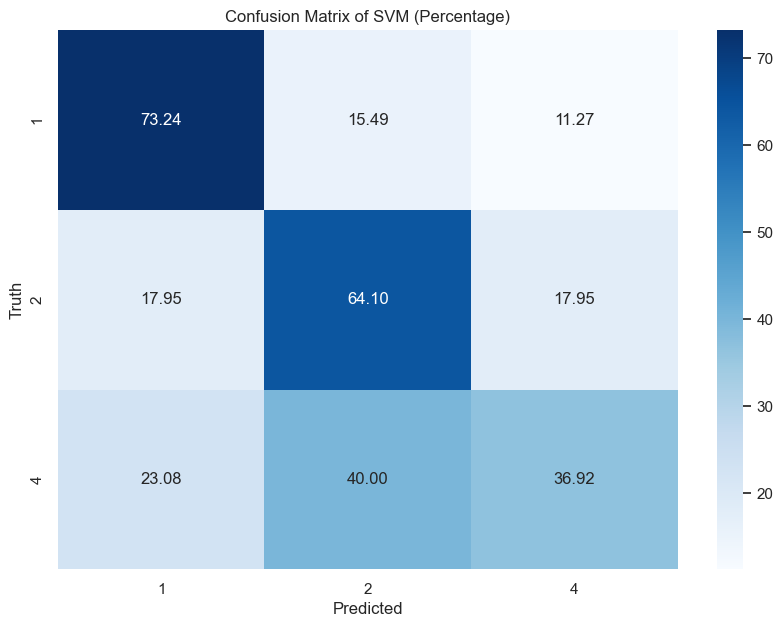

In [7]:
# 使用svm进行分类
from sklearn import svm  
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
  
# # 分离特征和目标变量
# X = data_no_g3_drop_duplicates_scaled_cleaned[['Gender', 'Total', 'MCQ','Q1','Q2','Q3','Q4','Q5']]  # 特征
# y = data_no_g3_drop_duplicates_scaled_cleaned['Programme']  # 目标变量（Programme）

# 确保X的列名是字符串
X.columns = X.columns.astype(str)

# X_in_tsne = tsne_df[['Dimension 1','Dimension 2','Dimension 3']]  # 特征
# y_in_tsne = tsne_df['Label']  # 目标变量

X_in_tsne = X_join_tsne[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Dimension 1','Dimension 2','Dimension 3']]  # 特征
y_in_tsne = y  # 目标变量
  
# 将数据分为训练集和测试集  
X_train, X_test, y_train, y_test = train_test_split(X_in_tsne, y_in_tsne, test_size=0.3, random_state=42)  

from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier
# Step 3: Undersample majority class
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

parameter_space = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # 误分类的惩罚参数  
    'gamma': ['scale'],  # 对于'rbf', 'poly' 和 'sigmoid'  
    'kernel': ['linear', 'rbf', 'poly','sigmoid', 'precomputed']  # 核函数类型  
}

# 创建SVM分类器对象  
svc = svm.SVC() 

# 创建SVM分类器对象  
clf_svm_best = GridSearchCV(svc, parameter_space, cv=5, n_jobs=8)  # 使用5折交叉验证
  
# 训练模型并搜索最佳参数
clf_svm_best.fit(X_resampled, y_resampled)


# 打印最佳参数  
print("Best parameters set found on development set:")  
print()  
print(clf_svm_best.best_params_)  
print()  
print("Grid scores on development set:")  
print()  
means = clf_svm_best.cv_results_['mean_test_score']  
stds = clf_svm_best.cv_results_['std_test_score']  
for mean, std, params in zip(means, stds, clf_svm_best.cv_results_['params']):  
    print("%0.3f (+/-%0.03f) for %r"  
          % (mean, std * 2, params))  
print()  


# 使用最佳参数在测试集上进行预测  
y_pred = clf_svm_best.predict(X_test)  
  
# 计算准确度  
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# 计算召回率  
# 注意：recall_score 需要一个额外的参数 'average'，指定如何计算多分类问题的召回率  
# 例如，可以使用 'micro', 'macro', 'weighted' 或针对每个类别的列表/数组  
recall = recall_score(y_test, y_pred, average='macro')  # 假设你想要计算宏平均召回率  
print(f"Recall: {recall}")
# 计算 F1 分数  
# 同样，f1_score 也需要一个 'average' 参数  
f1 = f1_score(y_test, y_pred, average='macro')  # 假设你想要计算宏平均 F1 分数  
print(f"F1 Score: {f1}")
# 或者，你可以使用 classification_report 来获取一个包含多个指标的详细报告  
report = classification_report(y_test, y_pred)  
print(report)

# # 获取所有唯一的类标签，并将它们转换为字符串（如果它们不是字符串的话）
# class_labels = y.unique().astype(str)


import numpy as np  
from sklearn.metrics import confusion_matrix  
import matplotlib.pyplot as plt  
import seaborn as sns  
  
# 假设你已经有了 y_test, y_pred, 并且 clf3 和 X_test 已经用于预测  
  
# 预测测试集的结果  
y_pred = clf_svm_best.predict(X_test)  
# 创建混淆矩阵  
cm = confusion_matrix(y_test, y_pred)  
# 获取类别标签的字符串形式  
class_names_str = [str(cls) for cls in sorted(y.unique())]  
  
# 计算每行的总和（也可以是每列的总和，取决于你想要展示哪种百分比）  
row_sums = cm.sum(axis=1, keepdims=True)  
# 避免除以零错误  
row_sums[row_sums == 0] = 1  
  
# 计算百分比并四舍五入到小数点后两位  
cm_percentage = (cm / row_sums) * 100  
cm_percentage = np.round(cm_percentage, 2)  
  
# 可视化混淆矩阵（百分比形式）  
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names_str, yticklabels=class_names_str)  
plt.xlabel('Predicted')  
plt.ylabel('Truth')  
plt.title('Confusion Matrix of SVM (Percentage)')  
plt.show()

Naive Bayes Classifier (Under_sampled Data) Performance:
Accuracy: 0.6161616161616161
Recall: 0.6161616161616161
F1 Score: 0.6068011837753045
Confusion Matrix:
 [[69  8  8]
 [ 9 14 19]
 [19 13 39]]
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.81      0.76        85
           2       0.40      0.33      0.36        42
           4       0.59      0.55      0.57        71

    accuracy                           0.62       198
   macro avg       0.57      0.56      0.56       198
weighted avg       0.60      0.62      0.61       198


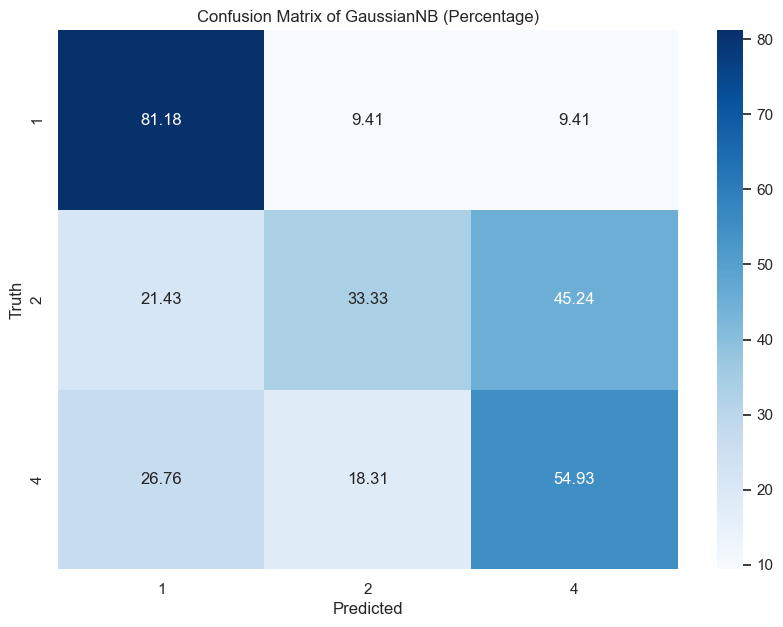


Balanced Bagging Classifier Performance:
Accuracy: 0.6212121212121212
Recall: 0.6212121212121212
F1 Score: 0.6107173354146435
Confusion Matrix:
 [[68  9  8]
 [ 9 13 20]
 [19 10 42]]
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.80      0.75        85
           2       0.41      0.31      0.35        42
           4       0.60      0.59      0.60        71

    accuracy                           0.62       198
   macro avg       0.57      0.57      0.57       198
weighted avg       0.61      0.62      0.61       198


In [8]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier

# Assuming data_no_g3 is your DataFrame containing the data

# # Step 2: Prepare data
# X_in_tsne = tsne_df[['Dimension 1','Dimension 2','Dimension 3']]  # 特征
# y_in_tsne = tsne_df['Label']  # 目标变量
X_in_tsne = X_join_tsne[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Dimension 1','Dimension 2','Dimension 3']]  # 特征
y_in_tsne = y  # 目标变量

# 确保X的列名是字符串
X.columns = X.columns.astype(str)
# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_in_tsne, y_in_tsne, test_size=0.34, random_state=42)

# Step 3: Undersample majority class
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

# Step 5: Build and train the Naive Bayes classifier on under_sampled data
gnb_under_sampled = GaussianNB()
gnb_under_sampled.fit(X_resampled, y_resampled)

# Step 6: Evaluate the Naive Bayes classifier on test data
y_pred_under_sampled = gnb_under_sampled.predict(X_test)
accuracy_under_sampled = accuracy_score(y_test, y_pred_under_sampled)
recall_under_sampled = recall_score(y_test, y_pred_under_sampled, average='weighted')
f1_under_sampled = f1_score(y_test, y_pred_under_sampled, average='weighted')
conf_matrix_under_sampled = confusion_matrix(y_test, y_pred_under_sampled)
class_report_under_sampled = classification_report(y_test, y_pred_under_sampled)

print("Naive Bayes Classifier (Under_sampled Data) Performance:")
print("Accuracy:", accuracy_under_sampled)
print("Recall:", recall_under_sampled)
print("F1 Score:", f1_under_sampled)
print("Confusion Matrix:\n", conf_matrix_under_sampled)
print("Classification Report:\n", class_report_under_sampled)

# 创建混淆矩阵  
cm = confusion_matrix(y_test, y_pred_under_sampled)  
# 获取类别标签的字符串形式  
class_names_str = [str(cls) for cls in sorted(y.unique())]  
# 计算每行的总和（也可以是每列的总和，取决于你想要展示哪种百分比）  
row_sums = cm.sum(axis=1, keepdims=True)  
# 避免除以零错误  
row_sums[row_sums == 0] = 1  
# 计算百分比并四舍五入到小数点后两位  
cm_percentage = (cm / row_sums) * 100  
cm_percentage = np.round(cm_percentage, 2)  
# 可视化混淆矩阵（百分比形式）  
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names_str, yticklabels=class_names_str)  
plt.xlabel('Predicted')  
plt.ylabel('Truth')  
plt.title('Confusion Matrix of GaussianNB (Percentage)')  
plt.show()



# Step 7: Build and train a Balanced Bagging classifier
bbc = BalancedBaggingClassifier(estimator=GaussianNB(), sampling_strategy='auto', n_estimators=20, random_state=42)
bbc.fit(X_train, y_train)

# Step 8: Evaluate the Balanced Bagging classifier on test data
y_pred_bbc = bbc.predict(X_test)
accuracy_bbc = accuracy_score(y_test, y_pred_bbc)
recall_bbc = recall_score(y_test, y_pred_bbc, average='weighted')
f1_bbc = f1_score(y_test, y_pred_bbc, average='weighted')
conf_matrix_bbc = confusion_matrix(y_test, y_pred_bbc)
class_report_bbc = classification_report(y_test, y_pred_bbc)

print("\nBalanced Bagging Classifier Performance:")
print("Accuracy:", accuracy_bbc)
print("Recall:", recall_bbc)
print("F1 Score:", f1_bbc)
print("Confusion Matrix:\n", conf_matrix_bbc)
print("Classification Report:\n", class_report_bbc)

Accuracy: 0.5260416666666666
Recall: 0.47889987986606347
F1 Score: 0.47673184515289774
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        81
           1       0.36      0.24      0.29        42
           2       0.47      0.51      0.49        69

    accuracy                           0.53       192
   macro avg       0.48      0.48      0.48       192
weighted avg       0.51      0.53      0.51       192


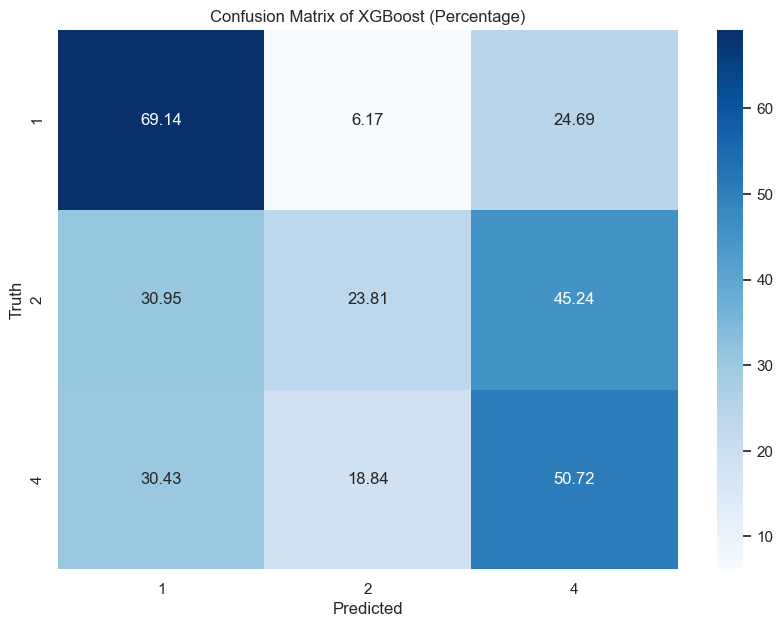

In [9]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder  
  
# 假设 data_no_g3 是已经加载好的 DataFrame  
# Step 2: Prepare data
# X_in_tsne = tsne_df[['Dimension 1','Dimension 2','Dimension 3']]  # 特征
# y_in_tsne = tsne_df['Label']  # 目标变量
X_in_tsne = X_join_tsne[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Dimension 1','Dimension 2','Dimension 3']]  # 特征
y_in_tsne = y  # 目标变量
  
# 将类别标签编码为从0开始的整数  
le = LabelEncoder()  
y_encoded = le.fit_transform(y)  
  
# 划分训练集和测试集  
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.33, random_state=42)  
# 创建XGBoost分类器实例  
xgb_clf = XGBClassifier(use_label_encoder=False, objective='multi:softmax', num_class=len(np.unique(y_encoded)))  
# 使用训练集训练模型  
xgb_clf.fit(X_train, y_train_encoded)  
# 使用测试集评估模型  
y_pred_encoded = xgb_clf.predict(X_test)  
# 将预测结果转换回原始标签（如果需要的话）  
y_pred = le.inverse_transform(y_pred_encoded)  
  
# 后续步骤：评估模型性能，进行预测等
# print(y_pred)
# print(y_test)
# 计算准确度  
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy}")
# 计算召回率  
# 注意：recall_score 需要一个额外的参数 'average'，指定如何计算多分类问题的召回率  
# 例如，可以使用 'micro', 'macro', 'weighted' 或针对每个类别的列表/数组  
recall = recall_score(y_test_encoded, y_pred_encoded, average='macro')  # 假设你想要计算宏平均召回率  
print(f"Recall: {recall}")
# 计算 F1 分数  
# 同样，f1_score 也需要一个 'average' 参数  
f1 = f1_score(y_test_encoded, y_pred_encoded, average='macro')  # 假设你想要计算宏平均 F1 分数  
print(f"F1 Score: {f1}")
# 或者，你可以使用 classification_report 来获取一个包含多个指标的详细报告  
report = classification_report(y_test_encoded, y_pred_encoded)  
print(report)


from sklearn.metrics import confusion_matrix   
# 创建混淆矩阵  
cm = confusion_matrix(y_test_encoded, y_pred_encoded)  
# 获取类别标签的字符串形式  
class_names_str = [str(cls) for cls in sorted(y.unique())]  
# 计算每行的总和（也可以是每列的总和，取决于你想要展示哪种百分比）  
row_sums = cm.sum(axis=1, keepdims=True)  
# 避免除以零错误  
row_sums[row_sums == 0] = 1  
# 计算百分比并四舍五入到小数点后两位  
cm_percentage = (cm / row_sums) * 100  
cm_percentage = np.round(cm_percentage, 2)  
# 可视化混淆矩阵（百分比形式）  
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names_str, yticklabels=class_names_str)  
plt.xlabel('Predicted')  
plt.ylabel('Truth')  
plt.title('Confusion Matrix of XGBoost (Percentage)')  
plt.show()

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters set found on development set:

{'learning_rate': 1.0, 'n_estimators': 11}
              precision    recall  f1-score   support

           1       0.83      0.64      0.72        85
           2       0.37      0.71      0.49        42
           4       0.62      0.45      0.52        71

    accuracy                           0.59       198
   macro avg       0.61      0.60      0.58       198
weighted avg       0.66      0.59      0.60       198


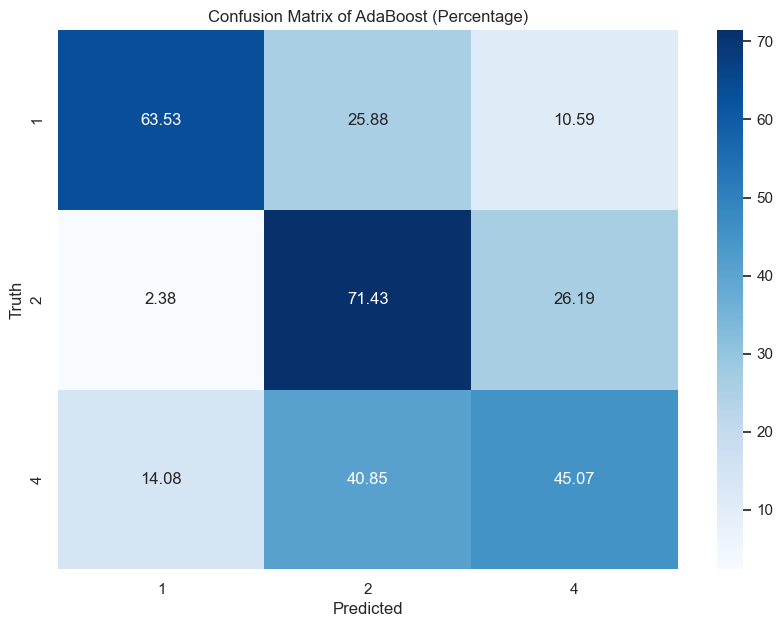

In [10]:
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.metrics import accuracy_score  
from imblearn.under_sampling import RandomUnderSampler  
  
# 假设你已经有了一个包含特征和标签的数据集  
# Step 2: Prepare data
# X_in_tsne = tsne_df[['Dimension 1','Dimension 2','Dimension 3']]  # 特征
# y_in_tsne = tsne_df['Label']  # 目标变量
X_in_tsne = X_join_tsne[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Dimension 1','Dimension 2','Dimension 3']]  # 特征
y_in_tsne = y  # 目标变量
  
# 确保X的列名是字符串（如果它们不是已经是的话）  
X.columns = X.columns.astype(str)  
  
# 将数据分为训练集和测试集  
X_train, X_test, y_train, y_test = train_test_split(X_in_tsne, y_in_tsne, test_size=0.34, random_state=42)  
  
# Step 3: Undersample majority class  
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)  
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)  

# 定义要搜索的超参数网格  
param_grid = {  
    'n_estimators': [i for i in range(10, 40, 1)],  # 尝试不同的弱学习器数量  
    'learning_rate': [1.0, 1.1, 1.2, 1.3],  # 尝试不同的学习率  
    # 你可以添加更多AdaBoostClassifier的超参数到param_grid中  
}
  
# Step 5: Build and train the AdaBoost classifier on under_sampled data  
# AdaBoostClassifier的默认基分类器是决策树桩（DecisionTreeClassifier(max_depth=1)）  
adb_under_sampled = AdaBoostClassifier(random_state=42, algorithm='SAMME')  
# 初始化GridSearchCV  
grid_search = GridSearchCV(estimator=adb_under_sampled, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=8)
# 在下采样后的数据上进行网格搜索  
grid_search.fit(X_resampled, y_resampled)
# 输出最佳参数  
print("Best parameters set found on development set:")  
print()  
print(grid_search.best_params_)

# 使用最佳参数构建最终的AdaBoost模型  
adb_best = AdaBoostClassifier(random_state=42, algorithm='SAMME', **grid_search.best_params_)  
adb_best.fit(X_resampled, y_resampled)  
  
# Step 6: Evaluate the AdaBoost classifier on test data  
y_pred_under_sampled = adb_best.predict(X_test)   


report = classification_report(y_test, y_pred_under_sampled)  
print(report)

from sklearn.metrics import confusion_matrix   
# 创建混淆矩阵  
cm = confusion_matrix(y_test, y_pred_under_sampled)  
# 获取类别标签的字符串形式  
class_names_str = [str(cls) for cls in sorted(y.unique())]  
# 计算每行的总和（也可以是每列的总和，取决于你想要展示哪种百分比）  
row_sums = cm.sum(axis=1, keepdims=True)  
# 避免除以零错误  
row_sums[row_sums == 0] = 1  
# 计算百分比并四舍五入到小数点后两位  
cm_percentage = (cm / row_sums) * 100  
cm_percentage = np.round(cm_percentage, 2)  
# 可视化混淆矩阵（百分比形式）  
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names_str, yticklabels=class_names_str)  
plt.xlabel('Predicted')  
plt.ylabel('Truth')  
plt.title('Confusion Matrix of AdaBoost (Percentage)')  
plt.show()

Accuracy: 0.5833333333333334
Recall: 0.5067223883649005
F1 Score: 0.4802905295818349
              precision    recall  f1-score   support

           1       0.74      0.75      0.75        81
           2       0.19      0.07      0.10        42
           4       0.51      0.70      0.59        69

    accuracy                           0.58       192
   macro avg       0.48      0.51      0.48       192
weighted avg       0.54      0.58      0.55       192


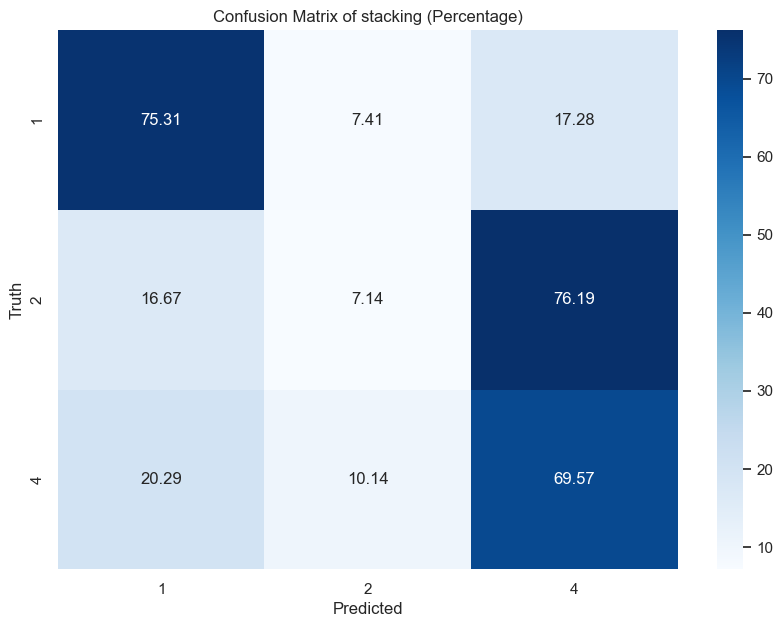

In [12]:
# stacking
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import StackingClassifier 
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler 
  
# 假设 data_no_g3 是已经加载好的 DataFrame  
# X = data_no_g3[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']]  # 特征  
# y = data_no_g3['Programme']  # 目标变量  

X_in_tsne = X_join_tsne[['Gender', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Dimension 1','Dimension 2','Dimension 3']]  # 特征
y_in_tsne = y  # 目标变量
  
# 划分数据集  
X_train, X_test, y_train, y_test = train_test_split(X_in_tsne, y_in_tsne, test_size=0.33, random_state=42)

# Step 3: Undersample majority class  
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)  
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)


# 定义基学习器  
base_learners = [  
    # ('rf', best_rf_classifier),  
    ('svm', clf_svm_best),
    ('adaBoost', adb_best),
    ('GNB', gnb_under_sampled),
    # # ('dt', best_dt_model),
    # ('tree_for_4', best_model_tree_for4),
    # ('tree_for_42', best_model_tree_for4),
]  
  
# 定义元学习器  
final_estimator = LogisticRegression()  
  
# 创建StackingClassifier  
stacking_clf = StackingClassifier(  
    stack_method= 'auto',
    estimators=base_learners,  
    final_estimator=final_estimator,  
    cv=4  # 交叉验证的折数，用于基学习器生成训练元学习器的特征
)  
  
# 训练StackingClassifier  
stacking_clf.fit(X_resampled, y_resampled)  
  
# 预测  
y_pred_re = stacking_clf.predict(X_test)  
  
# 计算准确度  
accuracy = accuracy_score(y_test, y_pred_re)
print(f"Accuracy: {accuracy}")
# 计算召回率  
# 注意：recall_score 需要一个额外的参数 'average'，指定如何计算多分类问题的召回率  
# 例如，可以使用 'micro', 'macro', 'weighted' 或针对每个类别的列表/数组  
recall = recall_score(y_test, y_pred_re, average='macro')  # 假设你想要计算宏平均召回率  
print(f"Recall: {recall}")
# 计算 F1 分数  
# 同样，f1_score 也需要一个 'average' 参数  
f1 = f1_score(y_test, y_pred_re, average='macro')  # 假设你想要计算宏平均 F1 分数  
print(f"F1 Score: {f1}")
# 或者，你可以使用 classification_report 来获取一个包含多个指标的详细报告  
report = classification_report(y_test, y_pred_re)  
print(report)


from sklearn.metrics import confusion_matrix   
# 创建混淆矩阵  
cm = confusion_matrix(y_test, y_pred_re)  
# 获取类别标签的字符串形式  
class_names_str = [str(cls) for cls in sorted(y.unique())]  
# 计算每行的总和（也可以是每列的总和，取决于你想要展示哪种百分比）  
row_sums = cm.sum(axis=1, keepdims=True)  
# 避免除以零错误  
row_sums[row_sums == 0] = 1  
# 计算百分比并四舍五入到小数点后两位  
cm_percentage = (cm / row_sums) * 100  
cm_percentage = np.round(cm_percentage, 2)  
# 可视化混淆矩阵（百分比形式）  
plt.figure(figsize=(10, 7))  
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names_str, yticklabels=class_names_str)  
plt.xlabel('Predicted')  
plt.ylabel('Truth')  
plt.title('Confusion Matrix of stacking (Percentage)')  
plt.show()